In [2]:
# Importing dependencies
import pandas as pd
import os
import numpy as np
from datetime import datetime
from glob import glob
from typing import List, Union, Iterator, Tuple
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input, Activation, Flatten, Concatenate,  MaxPooling2D, UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import ResNet50, Xception
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, History
from keras.optimizers import Adam, RMSprop, Adadelta
import keras_tuner as kt

In [3]:
def load_data(data_path: str) -> pd.DataFrame:
    """Loads data from csv file
    Params
    ------
    data_path: str
        Data path containing images and csv data
    Returns
    -------
    pd.DataFrame
        Loaded data as pandas dataframe
    """
    columns = ['image_id', 'angle', 'speed']
    data = pd.read_csv(os.path.join(data_path, 'training_norm.csv'), delimiter= ',', header=0, names = columns)

    return data

In [4]:
# Appends absolute path with image id column
def append_path(data: pd.DataFrame, data_path: os.PathLike) -> pd.DataFrame:
  data['image_id'] = data.image_id.apply(lambda x: os.path.join(data_path, 'training_data/', str(x)) + '.png')
  return data

## Data preprocessing

In [5]:
# train test split of dataset
def split_data(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Params
    ------
    data: pd.DataFrame
        Pandas dataframe containing all data.
    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of train, test and val split
    """
    rnd = np.random.RandomState(seed=None)

    train_data, val_data = train_test_split(data, test_size=0.2, random_state=rnd.seed(1234)) # split data with test size of 20%

    return train_data, val_data

In [6]:
data_path='machine-learning-in-science-ii-2023'
data = load_data(data_path)

In [7]:
data.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [8]:
data = append_path(data, data_path)

In [9]:
train_data, val_data = split_data(data)

In [10]:
# plotting distribution of output labels
def visualize(data):
    plt.hist(data.loc[:,'angle'])
    plt.hist(data.loc[:,'speed'])
    plt.legend(['Steering angle', 'Driving speed'])
    plt.title('Distribution plot for steering angle and speed')
    plt.grid(False)
    plt.show()

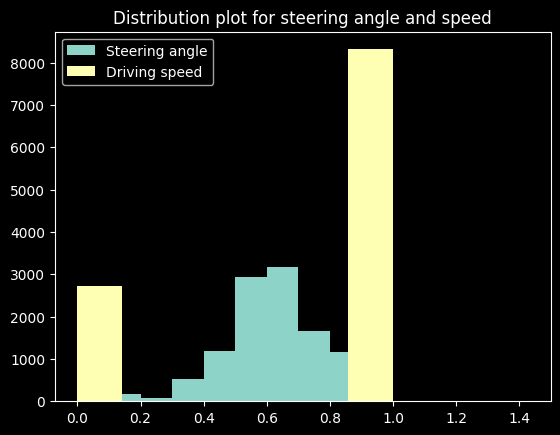

In [11]:
visualize(data=train_data)

## Data pipeline

In [12]:
# Generate images on the fly while training model
def img_generator(train_data: pd.DataFrame, val_data: pd.DataFrame, test_dir: os.PathLike, BATCH_SIZE: int, IMG_HEIGHT: int, IMG_WIDTH: int) -> Tuple[Iterator, Iterator]:
    """
    Params
    ------
    train_data: pd.DataFrame
        Pandas dataframe containing training data
    val_data: pd.DataFrame
        Pandas dataframe containing validation data
    test_dir: os.PathLike
        path to test data directory
    BATCH_SIZE: int
        Number of images to process in each batch
    IMG_HEIGHT: int
        image height
    IMG_WIDTH: int
        image width

    Returns
    -------
    Tuple[Iterator, Iterator]
        keras ImageDataGenerators used for training and validating model.
    """

    train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1
    )

    val_generator = ImageDataGenerator(rescale=1.0 / 255)
    test_generator = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_generator.flow_from_dataframe(dataframe=train_data,
                                                          directory=None,
                                                          x_col='image_id',
                                                          y_col=['angle','speed'],
                                                          color_mode='rgb',
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          class_mode='raw',
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True)

    val_generator = val_generator.flow_from_dataframe(dataframe=val_data,
                                                      x_col='image_id',
                                                      y_col=['angle', 'speed'],
                                                      color_mode='rgb',
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      class_mode='raw',
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True)
    
    test_generator = test_generator.flow_from_directory(
        directory=test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode='rgb',
        class_mode=None,
        classes=None,
        batch_size=BATCH_SIZE,
        seed=1234,
        shuffle=False)



    return train_generator, val_generator, test_generator


In [13]:
# create data generators for train test and val data
#training_ds, testing_ds, validation_ds = create_img_pipeline(train_ds, test_ds, val_ds)
BATCH_SIZE = 32
IMG_HEIGHT = 100
IMG_WIDTH = 100
test_dir = os.path.join(data_path, 'test_data')

train_generator, val_generator, test_generator = img_generator(train_data, val_data, test_dir=test_dir, BATCH_SIZE=BATCH_SIZE, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH)

Found 11034 validated image filenames.
Found 2759 validated image filenames.
Found 1020 images belonging to 1 classes.


In [14]:
# defining callbacks
def get_callbacks(model: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple keras callbacks

    Params
    ------
    model: str
        The name of model as a string

    Returns
    -------
    A list of multiple keras callbacks
    """
    logdir = (
        'logs/scalars/' + model + '_' + datetime.now().strftime('%Y%m%d-%H%M%S')
    ) # logging for each model
    tensorboard_callback = TensorBoard(log_dir=logdir)

    early_stopping_callback = EarlyStopping(
        monitor='loss',
        min_delta=0.01,  # model should improve by at least 0.1
        patience=10,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=1,
        mode='min',
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        './data/models/' + model + '.h5',
        monitor='loss',
        verbose=0,
        save_best_only=True,  # save the best model
        mode='min',
        save_freq='epoch',  # save the model on disk at end of every epoch
    )
    return [model_checkpoint_callback, tensorboard_callback, early_stopping_callback]

In [15]:
# create base model using transfer learning
def create_xception_model(input_shape, dropout_rate, optimizer) -> Sequential:
    """Creates a baseline model from MobileNetV2

    Params
    ------
    input_shape: input dimensions of image (224x224x3).
    dropout_rate: Applies Dropout to the input, to prevent over-fitting.
    optimizer: Optimization algorithm.

    Returns
    -------
    Sequential
        The keras model.
    """

    xception = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    #xception.trainable = False # Freeze the model
    # Set the last 5 layers to be trainable
    for layer in xception.layers[-5:]:
        layer.trainable = True

    model = Sequential([
        xception, 
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(2, activation='linear')], name='xception_model')

    # compile model
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mse', 'accuracy'])

    return model

In [16]:
lr = 2e-3 # learning rate
#decay = 0.01 # weight decay
dropout_rate = 0.2
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

optimizer = Adam(learning_rate=lr)  # optimizer

xception_model = create_xception_model(input_shape, dropout_rate, optimizer)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-16 14:31:13.211599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-16 14:31:13.211626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
xception_model.summary()

Model: "xception_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                    

In [18]:
## Train model with best hyperparameters
def train(name: str, model: Model, train_generator: Iterator, val_generator: Iterator, epoch: int, BATCH_SIZE: int) -> History:
    """
    Params
    ------
    name: str
        Model name
    model: keras.models.Model
        Model we are training
    train_generator: Iterator
        Image data generator for training
    val_generator: Iterator
        Image data generator for validation
    epoch: int
        Number of epochs to train for
    Returns
    -------
    keras.callbacks.History
    """
    callbacks = get_callbacks(name)

    history = model.fit(train_generator,
              epochs=epoch,
              steps_per_epoch=300,
              validation_data=val_generator,
              validation_steps=100,
              callbacks=callbacks,
              workers=4,
              verbose=1,
              batch_size=BATCH_SIZE)

    return history

In [19]:
tf.keras.backend.clear_session() # clear keras session

In [61]:
xception_history = train(name='xception_model', model=xception_model, train_generator=train_generator, val_generator=val_generator, epoch=50, BATCH_SIZE=BATCH_SIZE)

Epoch 1/50


2023-03-16 13:44:54.820231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - ETA: 0s - loss: 0.2900 - mse: 0.2900 - accuracy: 0.6941

2023-03-16 13:46:04.788031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 83s 245ms/step - loss: 0.2900 - mse: 0.2900 - accuracy: 0.6941 - val_loss: 0.0484 - val_mse: 0.0484 - val_accuracy: 0.9266
Epoch 2/50
300/300 [==============================] - 62s 205ms/step - loss: 0.0567 - mse: 0.0567 - accuracy: 0.8782 - val_loss: 0.0364 - val_mse: 0.0364 - val_accuracy: 0.8510
Epoch 3/50
300/300 [==============================] - 62s 205ms/step - loss: 0.0362 - mse: 0.0362 - accuracy: 0.9353 - val_loss: 0.0204 - val_mse: 0.0204 - val_accuracy: 0.9679
Epoch 4/50
300/300 [==============================] - 62s 207ms/step - loss: 0.0294 - mse: 0.0294 - accuracy: 0.9551 - val_loss: 0.0182 - val_mse: 0.0182 - val_accuracy: 0.9767
Epoch 5/50
300/300 [==============================] - 61s 203ms/step - loss: 0.0257 - mse: 0.0257 - accuracy: 0.9635 - val_loss: 0.0259 - val_mse: 0.0259 - val_accuracy: 0.9660
Epoch 6/50
300/300 [==============================] - 61s 202ms/step - loss: 0.0215 - mse: 0.0215 - accuracy: 0.9681 - val_los

In [25]:
xception_model.load_weights(filepath='./data/models/xception_model.h5')

In [26]:
def plot_history(history: History):
    """Plot training and validation loss for a model
    Params
    ------
    history: History
        Keras history callback
    Returns
    -------
    None
    """ 
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'lightblue', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'coral', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Xception model: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(False)
    plt.legend()
    plt.savefig('xception_model_plot.pdf')
    plt.show()

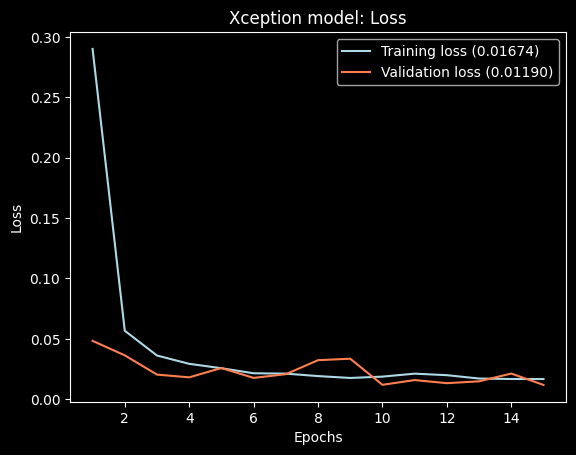

In [83]:
plot_history(xception_history)

In [27]:
def get_predictions(test_path: os.PathLike, test_generator: Iterator, model: Sequential) -> pd.DataFrame:
    """
    Params
    ------
    test_path: os.PathLike
        path to test data
    test_generator: Iterator
        Data generator for testing
    model: Sequential model
        trained model to make

    Returns
    -------
    pd.DataFrame
        predictions as pandas dataframe
    """
    # list of all png files in test data
    png_files = glob(f'{test_path}/*png')

    # convert to pandas dataframe with image_id as column name
    png_df = pd.DataFrame(data=png_files, columns=['image_id'])
    png_df['image_id'] = png_df.image_id.apply(lambda x: os.path.split(x)[-1].split('.png')[0])

    # make predictions
    pred = model.predict(test_generator)

    # convert prediction numpy.ndarray( to pd.DataFrame
    pred_df = pd.concat([png_df, pd.DataFrame(data=pred, columns=['angle', 'speed'])], axis=1)
    # dropping index from dataframe
    pred_df.reset_index(drop=True)

    # return predictions
    return pred_df

In [28]:
def save_csv(pred_df: pd.DataFrame) -> None:
    """
    Params
    ------
    pred_df: pd.DataFrame
        predictions in pandas dataframe

    Returns
    -------
    None
    """
    savedir='./submissions' # submissions directory
    if not os.path.exists(savedir):
        os.mkdir(savedir)

    csvfile = 'submission' + ' _' + datetime.now().strftime('%d-%b_%I-%M%p') + '.csv' # csv file name
    savedir = str(os.path.join(savedir, csvfile))
    pred_df.to_csv(savedir, sep=',', index=False) # save to disk
    print('Saved CSV file on disk!')

In [29]:
# directory that holds image data for testing
test_path = os.path.join(test_dir, 'images')

In [30]:
pred_df = get_predictions(test_path, test_generator=test_generator, model=xception_model)

2023-03-16 14:35:18.710310: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-16 14:35:19.107755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 5s 108ms/step


In [31]:
save_csv(pred_df)

Saved CSV file on disk!


In [32]:
pred_df.head()

,image_id,angle,speed
0,348,0.667612,-0.006725
1,412,0.580595,0.345606
2,374,0.559975,0.974746
3,360,0.162020,0.935089
4,406,0.181701,0.939384
